In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

seed_ = 20200218
tf.random.set_seed(seed_)
np.random.seed(seed_)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

import json

# RNN-LSTM (long short-term memory)

## Stack LSTM ต้องมี `return_sequences`

```
tf.keras.layers.LSTM(64, return_sequences=True)
tf.keras.layers.LSTM(32)
```

# Sacarsm

## Load Data

In [2]:
with open("./data/Sarcasm_Headlines_Dataset_v2.json", "r", encoding="utf-8") as f:
    lines = f.readlines()
    json_data = [json.loads(line) for line in lines]

In [3]:
json_data[:5]

[{'is_sarcastic': 1,
  'headline': 'thirtysomething scientists unveil doomsday clock of hair loss',
  'article_link': 'https://www.theonion.com/thirtysomething-scientists-unveil-doomsday-clock-of-hai-1819586205'},
 {'is_sarcastic': 0,
  'headline': 'dem rep. totally nails why congress is falling short on gender, racial equality',
  'article_link': 'https://www.huffingtonpost.com/entry/donna-edwards-inequality_us_57455f7fe4b055bb1170b207'},
 {'is_sarcastic': 0,
  'headline': 'eat your veggies: 9 deliciously different recipes',
  'article_link': 'https://www.huffingtonpost.com/entry/eat-your-veggies-9-delici_b_8899742.html'},
 {'is_sarcastic': 1,
  'headline': 'inclement weather prevents liar from getting to work',
  'article_link': 'https://local.theonion.com/inclement-weather-prevents-liar-from-getting-to-work-1819576031'},
 {'is_sarcastic': 1,
  'headline': "mother comes pretty close to using word 'streaming' correctly",
  'article_link': 'https://www.theonion.com/mother-comes-pretty-

In [4]:
df = pd.DataFrame(json_data)

In [5]:
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [6]:
df.shape

(28619, 3)

## Model

### prepare data

In [7]:
# config

num_words = 10000
embedding_dims = 32
max_length = 32
pad_trunc = 'post'
pad_type = 'pre'
oov_token = '<OOV>'

training_size = 20000

In [8]:
df_train = df.iloc[:training_size]
df_test = df.iloc[training_size:]

In [9]:
# tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=num_words, 
                                                  oov_token=oov_token)

In [10]:
tokenizer.fit_on_texts(df_train['headline'])
word_index = tokenizer.word_index

for k in list(word_index.keys())[:10]:
    print(f"{k}:\t{word_index[k]}")

<OOV>:	1
to:	2
of:	3
the:	4
in:	5
for:	6
a:	7
on:	8
and:	9
with:	10


In [11]:
train_sequences = tokenizer.texts_to_sequences(df_train['headline'])
test_sequences = tokenizer.texts_to_sequences(df_test['headline'])

In [12]:
padded_train = tf.keras.preprocessing.sequence.pad_sequences(
    train_sequences, maxlen=max_length, padding=pad_type, truncating=pad_trunc
)

padded_test = tf.keras.preprocessing.sequence.pad_sequences(
    test_sequences, maxlen=max_length, padding=pad_type, truncating=pad_trunc
)

# Model

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(num_words, embedding_dims),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64, return_sequences=True)
    ),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(32)
    ),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [14]:
optimizer = tf.keras.optimizers.Adam()

In [15]:
model.compile(optimizer=optimizer, metrics=['accuracy'], loss='binary_crossentropy')

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         49664     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 16)                1040      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 411,937
Trainable params: 411,937
Non-trainable params: 0
_________________________________________________________________


In [18]:
hist = model.fit(padded_train, 
          df_train['is_sarcastic'], 
          batch_size=64, epochs=15, 
          validation_data=(padded_test, df_test['is_sarcastic']))

Epoch 1/15
313/313 [==============================] - 12s 37ms/step - loss: 0.4307 - accuracy: 0.7852 - val_loss: 0.3291 - val_accuracy: 0.8535
Epoch 2/15
313/313 [==============================] - 10s 33ms/step - loss: 0.2284 - accuracy: 0.9093 - val_loss: 0.3436 - val_accuracy: 0.8467
Epoch 3/15
313/313 [==============================] - 10s 32ms/step - loss: 0.1442 - accuracy: 0.9470 - val_loss: 0.4265 - val_accuracy: 0.8448
Epoch 4/15
313/313 [==============================] - 10s 33ms/step - loss: 0.0940 - accuracy: 0.9676 - val_loss: 0.4499 - val_accuracy: 0.8387
Epoch 5/15
313/313 [==============================] - 10s 34ms/step - loss: 0.0637 - accuracy: 0.9804 - val_loss: 0.5097 - val_accuracy: 0.8420
Epoch 6/15
313/313 [==============================] - 10s 33ms/step - loss: 0.0437 - accuracy: 0.9859 - val_loss: 0.6379 - val_accuracy: 0.8391
Epoch 7/15
313/313 [==============================] - 10s 33ms/step - loss: 0.0316 - accuracy: 0.9906 - val_loss: 0.7295 - val_accuracy:

c:\users\chuan\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\users\chuan\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


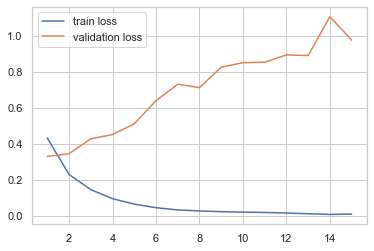

In [19]:
num_epochs = len(hist.history['loss'])
epochs = np.arange(1, num_epochs+1)

sns.lineplot(epochs, hist.history['loss'], label='train loss')
sns.lineplot(epochs, hist.history['val_loss'], label='validation loss')
plt.show()

c:\users\chuan\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\users\chuan\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


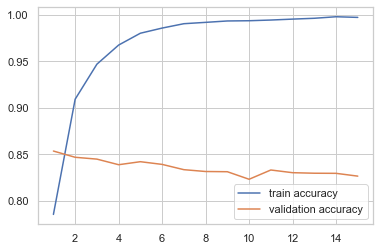

In [20]:
sns.lineplot(epochs, hist.history['accuracy'], label='train accuracy')
sns.lineplot(epochs, hist.history['val_accuracy'], label='validation accuracy')
plt.show()

## LSTM vs Simple NN

- acc ของ LSTM ไปได้สูงกว่า sim NN (ใน couse simple ตันที่ ~85%, lstm ~97.5%)
- acc validation drop แสดงว่าเกิด overfitting

In [21]:
df.to_csv("./data/Sarcasm_CSV.csv", index=False)